# Sort 2D projections by common lines

In [1]:
import mrcfile
import itertools
import numpy as np
from igraph import Graph
from scipy import ndimage as ndi
from skimage import transform, measure
from scipy import signal, spatial, stats

### inputs

In [2]:
#Path to mrcs file of 2D class averages
mrc_input = '../code_data_results/data/real_dataset/mixture_2D.mrcs'

#Path to star file for particles in 2D class averages
star_input = 'path/to/matching/mixture_particles.star'

#Path for output files
outpath = '../code_data_results/data/real_dataset/'

#Name for output file
description = 'l1_paper'

#Pixel size of 2D class averages in A/pixel
pixel_size = 1.1

#Choose metric for comparing 1D projections (NCC, cross-correlation, Euclidean, Norm-Euc, cosine, difference)
metric = 'difference'

#Number of edges for each node in the graph
neighbors = 5

#Community detection algorithm to use (betweenness, walktrap)
community_detection = 'betweenness'

In [3]:
#Set up angles for 2D->1D projections
interval = 5
angle = 360

#metrics to add 'sliding' feature too, analogous to cross-correlation
slide = ['Euclidean', 'Norm-Euc', 'cosine', 'difference']

### read in 2D projections

In [4]:
projection2d = {}

with mrcfile.open(mrc_input) as mrc:
    for i, data in enumerate(mrc.data):
        projection2d[i] = data.astype('float64')
        
#2D projections are named numerically to match mrcs file
file_names = list(range(len(projection2d)))

### extract class averages from background

In [5]:
#If using synthetic reprojections from EMAN, skip this block

for name, image in projection2d.items():
    #keep pixel values greater than the zero-mean, set everything else to zero
    #TODO: test different region extraction algorithms
    img_thresh = np.empty(image.shape)
    for i, row in enumerate(image):
        for j, pixel in enumerate(row):
            if image[(i,j)] < 0:
                img_thresh[(i,j)] = 0
            else:
                img_thresh[(i, j)] = image[(i,j)]
    
    #dilate by pixel size to connect neighbor regions
    extra = 3 #Angrstroms to dilate (set minimum of 3A)
    extend = int(np.ceil((pixel_size/extra)**-1))

    struct = np.ones((extend, extend), dtype=bool)
    dilate = ndi.binary_dilation(input=img_thresh, structure=struct)

    labeled = measure.label(dilate, connectivity=2, background=False)

    #select a single region from each 2D class average
    rprops = measure.regionprops(labeled, cache=False)
    bbox = [r.bbox for r in rprops]

    if len(bbox) == 1:
        #use only region in the image
        selected = 1

    elif len(bbox) > 1:
        img_x_center = len(image)/2
        img_y_center = len(image[:,0])/2
        img_center = (img_x_center, img_y_center)
        #for use in distance calculation
        x1 = np.array(img_center)

        box_range = {}
        for i, box in enumerate(bbox):
            width_coord = list(range(box[1], box[3]+1))
            length_coord = list(range(box[0], box[2]+1))
            box_range[i+1] = [width_coord, length_coord]

        box_centers = {}
        for i, box in enumerate(bbox):
            y_max, y_min = box[0], box[2]
            x_max, x_min = box[1], box[3]
            center_xy = (((x_max+x_min)/2, (y_max+y_min)/2))
            #i+1 because 0 is the background region
            box_centers[i+1] = center_xy

        selected = 'none'

        for region, bound in box_range.items():
            #first check if there is a region in the center
            if img_x_center in bound[0] and img_y_center in bound[1]:
                #use center region
                selected = region

        if selected == 'none':
            #find box closest to the center    
            distance = {}
            for region, center in box_centers.items():
                x2 = np.array(center)
                distance[region] = spatial.distance.euclidean(x1, x2)  
            region = min(distance, key=distance.get) 
            #use region closest to center
            selected = region

    selected_region = (labeled == selected)

    properties = measure.regionprops(selected_region.astype('int'))
    bbox = properties[0].bbox

    y_min, y_max = bbox[0], bbox[2]
    x_min, x_max = bbox[1], bbox[3]
    
    #keep only true pixels in bounding box
    true_region = np.empty(image.shape)
    
    for i, row in enumerate(image):
        for j, pixel in enumerate(row):
            if selected_region[(i,j)] == True:
                true_region[(i,j)] = image[(i, j)]
            else:
                true_region[(i,j)] = 0
                
    new_region = true_region[y_min:y_max, x_min:x_max]
    
    projection2d[name] = new_region

### create 1d projection vectors

In [6]:
n_projections = len(projection2d)
print('\n'+'calculting line scores for {0} pairs of projections'\
      .format(int((n_projections**2)/2 + (n_projections/2))))

#Keep projections as a list to slice later
projection_1D = []

rot_angles = np.arange(0, angle+1, interval)

#Rotate and project to 1D on x-axis, effectively creates a sinogram
for key, projection in projection2d.items():
    for angle in rot_angles:
        proj_1D = transform.rotate(projection, angle).sum(axis=0)
        if metric == 'NCC' or metric == 'norm-Euc':
            norm_proj_1D = stats.zscore(proj_1D) 
            projection_1D.append([(key, angle), norm_proj_1D])
        else:
            projection_1D.append([(key, angle), proj_1D])


calculting line scores for 5050 pairs of projections


### sliding vector comparisons

In [7]:
score_matrix = {}

#Calculate sliding vector scores to account for translations in 1D projections
if metric in slide:
    for i, proj_1 in enumerate(projection_1D):
        lp1 = len(proj_1[1])
        #slice to calculate upper triangular matrix
        for proj_2 in projection_1D[i:]:
            lp2 = len(proj_2[1])
            dol = abs(lp1 - lp2)
            proj_shift = []

            if dol == 0:
                if metric == 'difference':
                    score = sum(abs(proj_1[1] - proj_2[1]))
                elif metric == 'Euclidean' or metric == 'Norm-Euc':
                    score = spatial.distance.euclidean(proj_1[1], proj_2[1])
                elif metric == 'cosine':
                    score = spatial.distance.cosine(proj_1[1], proj_2[1])

            #store position and score of minimum 
            elif lp1 < lp2:
                static = proj_2[1]
                for i in range(0, dol+1):
                    proj_shift.append(np.pad(proj_1[1], pad_width=(i, dol-i), mode='constant'))
            elif lp1 > lp2:
                static = proj_1[1]
                for i in range(0, dol+1):
                    proj_shift.append(np.pad(proj_2[1], pad_width=(i, dol-i), mode='constant'))
            else:
                print('something is wrong with the 1D projections')

            if dol != 0:
                scores = []
                for shift in proj_shift:
                    if metric == 'difference':
                        val = sum(abs(static - shift))
                    elif metric == 'Euclidean' or metric == 'Norm-Euc':
                        val = spatial.distance.euclidean(static, shift)
                    elif metric == 'cosine':
                        val = spatial.distance.cosine(static, shift)
                    scores.append(val)
                #metrics in 'slide' are dissimilarity, smaller values are better
                score = min(scores)
            #format for score_matrix [proj_1, angle_1, proj_2, angle_2] = score
            score_matrix[proj_1[0][0], proj_1[0][1], proj_2[0][0], proj_2[0][1]] = score
            
elif metric == 'cross-correlation' or metric == 'NCC':
    for i, proj_1 in enumerate(projection_1D):
        for proj_2 in projection_1D[i:]:
            score = signal.correlate(proj_1[1], proj_2[1], mode='valid')
            score_matrix[proj_1[0][0], proj_1[0][1], proj_2[0][0], proj_2[0][1]] = score          
    for key, array in score_matrix.items():
        score_matrix[key] = np.amax(array)

In [8]:
#optional output of all scores (this is a large text file! 100 projections --> 2.6*10^7 lines)

#with open(outpath+'/{0}_raw_scores.txt'.format(description), 'w') as f:
#    f.write('projection_1' + '\t' + 'angle_1' + '\t' +'projection_2' + '\t' + 'angle_2' + '\t' + 'score' + '\n')
#    for key, value in score_matrix.items():
#        f.write(str(key[0]) +'\t'+ str(key[1]) +'\t'+ str(key[2]) +'\t'+ str(key[3]) +'\t'+ '%f'%(value) + '\n')

###  final common line scores

In [9]:
#Get the optimum score for each pair of projection images 

final_scores = {}
complete_score_matrix = {}

#Generate pairs for the number of 2D projections
pairs = list(itertools.combinations_with_replacement(file_names, 2))

#Initialize final score (proj1, proj2) = [score, angle_proj1, angle_proj2]
final_scores = {pair: [score_matrix[pair[0], 0, pair[1], 0], 0, 0] for pair in pairs}

if metric in slide: 
    for key, value in score_matrix.items():
        if value < final_scores[(key[0], key[2])][0]:
            final_scores[(key[0], key[2])][0] = value
            final_scores[(key[0], key[2])][1] = key[1]
            final_scores[(key[0], key[2])][2] = key[3]

elif metric == 'cross-correlation' or metric == 'NCC':
    for key, value in score_matrix.items():
        if value > final_scores[(key[0], key[2])][0]:
            final_scores[(key[0], key[2])][0] = value
            final_scores[(key[0], key[2])][1] = key[1]
            final_scores[(key[0], key[2])][2] = key[3]
            
for key, value in final_scores.items():
    complete_score_matrix[key] = value
    score = value[0]
    angle_1 = value[1]
    angle_2 = value[2]
    complete_score_matrix[(key[1], key[0])] = [score, angle_2, angle_1]

### nearest neighbors

In [10]:
proj_scores = {}

for i in range(len(projection2d)):
    proj_scores[i] = []
    for j in range(len(projection2d)):
        proj_scores[i].append(complete_score_matrix[(i, j)][0])
        
    #TODO: apply different edgeweighting strategies
    zscores = stats.zscore(proj_scores[i])
    proj_scores[i] = zscores
    
proj_knn = {key: [] for key in range(len(projection2d))}

for projection, scores in proj_scores.items():
    sort_scores = sorted((score, i) for i, score in enumerate(proj_scores[projection]))
    if metric not in slide:
        sort_scores = sorted(sort_scores, reverse=True)
    count = 0
    for zscore in sort_scores:
        if count < neighbors and zscore[1] != projection:
            #proj_knn format is (proj_1) = [[score, (proj_1, angle_1, proj_2, angle_2)]]
            proj_knn[projection].append([abs(zscore[0]),\
                                        (projection,\
                                         complete_score_matrix[(projection, zscore[1])][1],\
                                         zscore[1],\
                                         complete_score_matrix[(projection, zscore[1])][2])])
            count = count + 1

### cluster 2d projections

In [45]:
flat = []

for proj, neighbors in proj_knn.items():
    for n in neighbors:
        #(proj_1, proj_2, score)
        flat.append((str(proj), str(n[1][2]), n[0]))

g = Graph.TupleList(flat, weights=True)

if community_detection == 'walktrap':
    wt = Graph.community_walktrap(g, weights='weight', steps=4)
    cluster_dendrogram = wt.as_clustering()
elif community_detection == 'betweenness':
    ebs = Graph.community_edge_betweenness(g, weights='weight', directed=True)
    cluster_dendrogram = ebs.as_clustering()

clusters = {}
for comm, proj in enumerate(cluster_dendrogram.subgraphs()):
    clusters[comm] = proj.vs['name']

#Convert vertex IDs back to int
for key, comm in clusters.items():
    clusters[key] = [int(proj) for proj in comm]

InternalError: Error at src/community/community_misc.c:112: Number of steps is greater than number of rows in merges matrix: found 99 steps, 98 rows. -- Invalid value

In [43]:
graph_names = [elt["name"] for elt in list(g.vs)]
graph_names

['0',
 '96',
 '98',
 '32',
 '56',
 '6',
 '1',
 '50',
 '89',
 '88',
 '44',
 '13',
 '2',
 '34',
 '31',
 '46',
 '81',
 '55',
 '3',
 '38',
 '4',
 '59',
 '41',
 '36',
 '8',
 '83',
 '5',
 '26',
 '62',
 '66',
 '33',
 '28',
 '21',
 '7',
 '20',
 '52',
 '74',
 '9',
 '93',
 '14',
 '49',
 '63',
 '67',
 '10',
 '39',
 '11',
 '40',
 '37',
 '22',
 '12',
 '48',
 '60',
 '64',
 '91',
 '92',
 '58',
 '80',
 '78',
 '15',
 '23',
 '27',
 '35',
 '16',
 '87',
 '45',
 '17',
 '65',
 '18',
 '19',
 '51',
 '82',
 '68',
 '77',
 '61',
 '30',
 '43',
 '24',
 '25',
 '94',
 '72',
 '29',
 '86',
 '42',
 '97',
 '47',
 '57',
 '54',
 '53',
 '70',
 '73',
 '75',
 '84',
 '71',
 '69',
 '85',
 '76',
 '90',
 '79',
 '95',
 '99']

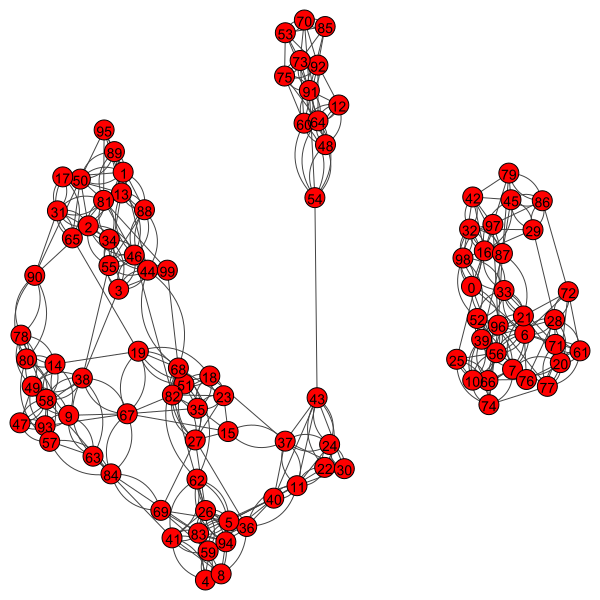

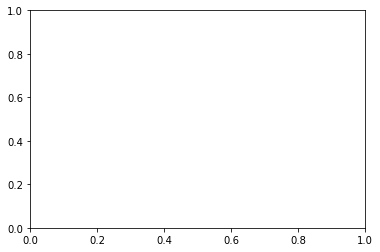

In [44]:
import igraph as ig
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ig.plot(g, target=outpath+'graph_vis.pdf',vertex_label=graph_names)

In [46]:
test_g = g.copy()


In [48]:
test_g.delete_edges([('54','43')])

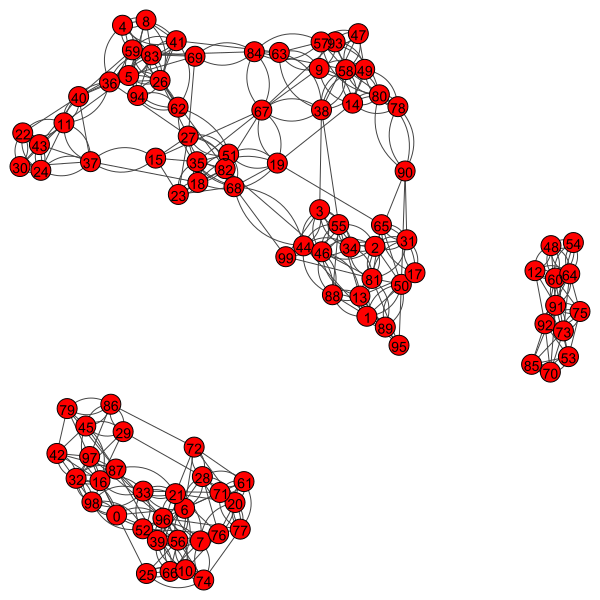

In [49]:
ig.plot(test_g, target=outpath+'graph_vis_clus.pdf',vertex_label=graph_names)

In [52]:
test_g

In [56]:
components = test_g.clusters() # Get strong or weak connected components 
components

In [63]:
with open(outpath+'/{0}_clusters_3.txt'.format(description), 'w') as f:
    for i, cluster in enumerate(list(components)):
        f.write(str(i) + '\t' + str(cluster) + '\n')

In [19]:
def fix_dendrogram(graph, cl):
    already_merged = set()
    for merge in cl.merges:
        already_merged.update(merge)
        
    print(already_merged)

    num_dendrogram_nodes = graph.vcount() + len(cl.merges)
    not_merged_yet = sorted(set(range(num_dendrogram_nodes)) - already_merged)
    if len(not_merged_yet) < 2:
        print('len(not_merged_yet) < 2')
        return

    v1, v2 = not_merged_yet[:2]
    cl._merges.append((v1, v2))
    del not_merged_yet[:2]

    missing_nodes = range(num_dendrogram_nodes,num_dendrogram_nodes + len(not_merged_yet))
    cl._merges.extend(zip(not_merged_yet, missing_nodes))
    cl._nmerges = graph.vcount()-1
    
    return cl

In [20]:
ebs_fixed = fix_dendrogram(g, ebs)

cluster_dendrogram = ebs_fixed.as_clustering()

clusters = {}
for comm, proj in enumerate(cluster_dendrogram.subgraphs()):
    clusters[comm] = proj.vs['name']

#Convert vertex IDs back to int
for key, comm in clusters.items():
    clusters[key] = [int(proj) for proj in comm]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196}


In [28]:
clusters

{0: [0,
  96,
  98,
  32,
  56,
  6,
  1,
  50,
  89,
  88,
  44,
  13,
  2,
  34,
  31,
  46,
  81,
  55,
  3,
  38,
  4,
  59,
  41,
  36,
  8,
  83,
  5,
  26,
  62,
  66,
  33,
  28,
  21,
  7,
  20,
  52,
  74,
  9,
  93,
  14,
  49,
  63,
  67,
  10,
  39,
  11,
  40,
  37,
  22,
  12,
  48,
  60,
  64,
  91,
  92,
  58,
  80,
  78,
  15,
  23,
  27,
  35,
  16,
  87,
  45,
  17,
  65,
  18,
  19,
  51,
  82,
  68,
  77,
  61,
  30,
  43,
  24,
  25,
  94,
  72,
  29,
  86,
  42,
  97,
  47,
  57,
  54,
  70,
  75,
  84,
  71,
  69,
  85,
  76,
  79,
  95,
  99]}

### remove outliers from clusters

In [24]:
#Use median absolute deviation of summed 2D projections to remove outliers
#Evaluate outliers for further processing

pixel_sums = {}

for cluster, nodes in clusters.items():
    pixel_sums[cluster] = []
    for node in nodes:
        pixel_sums[cluster].append(sum(sum(projection2d[node])))

for cluster, psums in pixel_sums.items():
    med = np.median(psums)
    m_psums = [abs(x - med) for x in psums]
    mad = np.median(m_psums)
    
    for i, proj in enumerate(psums):
        #Boris Iglewicz and David Hoaglin (1993)
        z = 0.6745*(proj - med)/mad
        if abs(z) > 3.5:
            print('projection node {0} was removed from cluster {1} as an outlier'\
                  .format(clusters[cluster][i], cluster))
            clusters[cluster].pop(i)

projection node 53 was removed from cluster 0 as an outlier
projection node 73 was removed from cluster 0 as an outlier
projection node 90 was removed from cluster 0 as an outlier


### score output files

In [15]:
#Complete score matrix output
#Output is tab separated: projection_1, angle_1, projection_2, angle_2, score
with open(outpath+'/complete_scores_{0}.txt'.format(description), 'w') as f:
    f.write('projection_1' + '\t' + 'angle_1' + '\t' +'projection_2' +\
            '\t' + 'angle_2' + '\t' + 'score' + '\n')
    for key, value in complete_score_matrix.items():
        f.write(str(key[0]) +'\t'+ str(value[1]) +'\t'+ str(key[1]) +'\t'+\
                str(value[2]) +'\t'+ '%f'%(value[0]) + '\n')
        
#Nearest neighbors output
#Output is tab separated: projection_1, angle_1, projection_2, angle_2, score    
with open(outpath+'/neighbors_{0}.txt'.format(description), 'w') as f:
    f.write('projection_1' + '\t' +'angle_1' + '\t'\
            + 'projection_2' + '\t' + 'angle_2' + '\t' + 'edge_score' + '\n')
    for key, value in proj_knn.items():
        for item in value:
            f.write(str(key) + '\t' + str(item[1][1]) + '\t'\
                    + str(item[1][2]) + '\t' + str(item[1][3]) + '\t' + str(item[0]) + '\n')        

In [14]:
#Output is tab separated: projection_1, angle_1, projection_2, angle_2, score    
with open(outpath+'/slicem_edge_list_{0}.txt'.format(description), 'w') as f:
    for key, value in proj_knn.items():
        for item in value:
            f.write(str(key) + '\t' 
                    + str(item[1][2]) +  '\t' + str(item[0]) + '\n')      

### output cluster star files

In [25]:
h_count = 0
header = []
class_average = {}

with open(star_input) as f:
    for raw_line in f:
        line = raw_line.rstrip('\n').split()
        h_count = h_count + 1
        if h_count < 33:
            header.append(line)
        else:
            #skip blank lines
            if len(line) > 10:
                #line[23]-1 because relion index starts at 1, mrc and clusters start at 0
                if int(line[23])-1 in class_average:
                    class_average[int(line[23])-1].append(line)
                else:
                    class_average[int(line[23])-1] = [line]



FileNotFoundError: [Errno 2] No such file or directory: 'path/to/matching/mixture_particles.star'

In [26]:
#Format header for output
for i, entry in enumerate(header):
    if i == 1:
        header[i] = ['\n'+str(header[i][0])+'\n']
    if len(entry) > 1:
        header[i] = [' '.join(entry)]
        
flat_header = [entry for sub in header for entry in sub]

output = {cluster: [] for cluster, proj in clusters.items()}

for cluster, averages in clusters.items():
    for average in averages:
        output[cluster].append(class_average[average])

for cluster, data in output.items():
    with open(outpath+'/{0}_cluster_{1}.star'.format(description, cluster), 'w') as f:
        f.write('\n'.join(flat_header)+'\n')
        for particle_list in data:
            for particles in particle_list:
                f.write('\t'.join(particles)+'\n')


KeyError: 0

In [27]:
             
with open(outpath+'/{0}_clusters.txt'.format(description), 'w') as f:
    for cluster, averages in clusters.items():
        f.write(str(cluster) + '\t' + str(averages) + '\n')